# Code for the lick plots
The core plots related to licks are generated in this program. Usually they are slightly adjusted in Inkscape later. We get the data we need from the database with a query, store this data in a pandas dataframe and use the seaborn library to plot the data. To visualize the data you can log in into our online database and use the GUI to run the queries (without the triple quotes)

available plots: 

"facetgrid"

"outcome_patterns"

"single_session"

"parameters"

#### this makes all plots

"all"

### please specify the function you want to run in the run variable

In [23]:
run = "all"

#### At the beginning we import libraries and define the database connection
here is no adjustment required

In [24]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import pymysql
import seaborn as sns
from password import database_password as DBpwd
from password import database_user as DBuser
from password import database_host as DBhost
from password import database as DB


analize_licks = False

#????????????????????????????????get data from database and preprocessing functions???????????????????????????????????

# get data from database. usually no adjustments required
def getFromDatabase(query):
    db2 = pymysql.connect(host=DBhost, user=DBuser, db=DB, password=DBpwd)
    cur2 = db2.cursor()
    try:
        cur2.execute(query) #, (GO,MOUSE)
        rows = cur2.fetchall()
    except pymysql.Error as e:
        try:
            print("MySQL Error [%d]: %s" % (e.args[0], e.args[1]))
            return None
        except IndexError:
            print("MySQL Error: %s" % str(e))
            return None
    except TypeError as e:
        print("MySQL Error: TypeError: %s" % str(e))
        return None
    except ValueError as e:
        print("MySQL Error: ValueError: %s" % str(e))
        return None
    db2.close()
    return rows

### The parameter plot in Fig.6C
unfortunately the parameters are not saved, so we use the daily minimum of the GO=2 outcomes to estimate them. Therefore we need a round function that rounds down to 0.05 accuracy, which was the adjustment we did. In this figure we use the data from group4 and hence the query uses the timestamps of its headfix protocol, but it can be modified if there is interest in other cages. Don't forget to adjust the line to the right reference date

`df["Day"] = (df["Date"] - pd.to_datetime("2018-08-08")).dt.days`

In [25]:
def myround(x, base=5):
    return int(base * math.floor(float(x*100)/base))/100

#?????????????????????????????plots?????????????????????????????????????????????????
def draw_parameters():
    query = """SELECT Date(`Trial start`) AS `Date`, ROUND(MIN(`Reaction time`),2)
                FROM `headfix_trials_summary`
                WHERE `Fixation` = "fix" AND `Notes` = "GO=2" AND
                 (Date(headfix_trials_summary.`Trial start`) BETWEEN "2018-08-08" and "2018-10-23")              
                GROUP BY `Date`, `Notes`"""
    
    data = list(getFromDatabase(query=query))
    df = pd.DataFrame(data=data, columns=["Date", "lickdelay_min"])
    # set the timestamp to datetime, sometimes pandas doesn't exactly know what data type it is getting
    df["Date"] = pd.to_datetime(df["Date"])
    # calculate the day of protocol
    df["Day"] = (df["Date"] - pd.to_datetime("2018-08-08")).dt.days
    
    # round them by adjusting them to the minimum, rounded down to either 0.x5 or 0.x values. iteration over DF is backwards:
    # idea: we always increase the value and we always have nice numbers. first values are definetely 0.35 in cage4
    current_minumum = 1.2
    df = df.iloc[::-1]
    for index, row in df.iterrows():
        current_value = row["lickdelay_min"]
        current_minumum = myround(min(current_value, current_minumum))
        df.loc[index, "Lickdelay_time"] = current_minumum
    df1 = df.iloc[::-1]
    
    # figure plotting
    fig = plt.figure(figsize=(4.4, 2.2))
    sns.set_context("paper", font_scale=1.75, rc={"lines.linewidth": 5})
    a= sns.lineplot(data=df1, x="Day", y="Lickdelay_time", legend=False)
    a.set(xlabel="", ylabel="")
    sns.despine()
    plt.yticks([0.35,0.7,1.1])
    plt.tight_layout()
    plt.savefig("parameters.svg",bbox_inches=0, transparent=True)
    plt.show()

### This plot draws events on a timeline, like used for Fig.5A
The code simply takes events and corresponding timestamps from the database and plots them as rugs on a timeline with different sizes and colors. Was further styled in Inkscape for the paper but all events are drawn. Especially the LED and headfix events are very small lines because they were made with shadows in Inkscape. If intended they can be simply drawn bigger by changing the `height` and `linewidth` variables in the code. The code simply works by making a plot for each event type and overlaying the plots, which is a feature of `seaborn`.

Which session will be drawn has to be specified by the used timestamps. To draw sessions it's easiest to look up a session of interest in the video table because it shows the outcomes on one glance. Copy the timestamp of the `session start` and call a query like

``SELECT * FROM `textfiles` WHERE `Timestamp` > "2017-07-19 16:40:23.35"``

using the copied timestamp reduced by a few seconds. Then look up the timestamps of `entry` and `exit` and use them in your final query.

In [26]:
def draw_single_session():
    
    sns.set_context("talk")
    # query
    query = """SELECT `Timestamp`,`Event` FROM `textfilesgroup4` WHERE `Timestamp`
    BETWEEN "2018-09-25 04:09:54.78" AND "2018-09-25 04:10:43.47" """
    
    liste = list(getFromDatabase(query=query))
    df_trials = pd.DataFrame(data=liste, columns=["Timestamp", "Event"])
    df_trials["Time"] = (df_trials["Timestamp"] - df_trials["Timestamp"].iloc[0]).dt.total_seconds()
    #print(df_trials)
    fig = plt.figure(figsize=(15,5))
    #entry exit
    a = df_trials.loc[df_trials['Event'].isin(["exit", "entry"]), "Time"]
    b = sns.rugplot(a=a, height=0.1, color="limegreen", linewidth=4,label="Entry/Exit",linestyle = "-")
    #reward
    a = df_trials.loc[df_trials['Event'].isin(["reward","entryReward"]), "Time"]
    b = sns.rugplot(a=a, height=0.18,color="royalblue",linewidth=4,label="Water reward")
    #stimulus
    a = df_trials.loc[df_trials['Event'].str.contains("GO=-1|GO=1|GO=-3"), "Time"]
    b = sns.rugplot(a=a, height=0.24, color="darkred", linewidth=4,label="NO GO stimulus",linestyle = "--")
    a = df_trials.loc[df_trials['Event'].str.contains("GO=-2|GO=2|GO=-4"), "Time"]
    b = sns.rugplot(a=a, height=0.24, color="darkred", linewidth=4,label="GO stimulus")
    #licks
    a = df_trials.loc[df_trials['Event'].isin(["lick:1", "lick:2"]), "Time"]
    b = sns.rugplot(a=a, height=0.06, color="black", linewidth=1.5,label="Licks")
    b.legend(frameon=False)
    #headfix times
    a = df_trials.loc[df_trials['Event'].isin(["check+","complete"]), "Time"]
    b = sns.rugplot(a=a, height=0.02, color="r",linewidth=0.5,alpha=1)
    #LED
    a = df_trials.loc[df_trials['Event'].isin(["BrainLEDON", "BrainLEDOFF"]), "Time"]
    b = sns.rugplot(a=a, height=0.02, color="r", linewidth=0.5,alpha=1)
    #plot adjustment
    sns.set(style="white")
    sns.despine(left=True)
    plt.tick_params(labelsize=20,size=25)
    plt.xlabel("Time [s]",fontsize=20)
    plt.ylim(0.2)
    plt.xlim(-2,52)
    plt.tight_layout()
    plt.yticks([])
    plt.savefig("fullsession.svg",bbox_inches=0, transparent=True)
    plt.show()

### This plot shows lick probability of all licks under headfix protocol and a licking required task of all cages
This plot is not used in the paper, but shows all licks of all mice and all cages as probability. Timestamps are used to pick the related data, and the dates can be found in the `major_dates` table. Displayed y-axis can also be changed to absolute licks by changing ``norm_hist=False``, but since the outcomes occur with different amount the `GO=2` outcome will be very dominant. Picking the outcomes that are actually interesting can be done with the line by selecting the outcomes. For all outcomes this line can also be removed

``AND `headfix_trials_summary`.`Notes` IN ("GO=2","GO=-4","GO=-2","GO=1","GO=-1","GO=-3","GO=0")``

In [27]:
def draw_outcome_patterns():
    
    query = """SELECT licks.Mouse,licks.`Timestamp`, licks.Delta_time, headfix_trials_summary.Notes,
                headfix_trials_summary.Project_ID FROM `licks`
                inner JOIN `headfix_trials_summary` ON `licks`.`Related_trial` = `headfix_trials_summary`.`Trial start`
                WHERE `headfix_trials_summary`.`Fixation` = "fix" and 
        ((Date(headfix_trials_summary.`Trial start`) between "2017-08-28" and "2017-10-12") OR 
        (Date(headfix_trials_summary.`Trial start`) between "2018-02-19" and "2018-04-01") OR 
        (Date(headfix_trials_summary.`Trial start`) between "2018-04-28" and "2018-06-01") OR 
        (Date(headfix_trials_summary.`Trial start`) between "2018-08-08" and "2018-10-23") OR 
        (Date(headfix_trials_summary.`Trial start`) between "2018-11-23" and "2018-12-20")) 
         AND licks.Delta_time between -3 and 5 AND `headfix_trials_summary`.`Licks_within_lickwithhold_time` IS NULL
         AND `headfix_trials_summary`.`Notes` IN ("GO=2","GO=-4","GO=-2","GO=1","GO=-1","GO=-3","GO=0")
        """
    
    data = list(getFromDatabase(query = query))
    df = pd.DataFrame(data=data, columns=["Mouse", "Timestamp", "Delta_time", "Outcome", "Cage"])
    grid = sns.FacetGrid(df, col="Outcome", hue="Outcome")
    grid.map(sns.distplot, "Delta_time", bins=100, kde=False, hist=True, norm_hist=True, kde_kws={"label": "licks"})
    sns.despine()
    plt.xlim(-4, 4)
    plt.tight_layout()
    plt.show()

### This plot shows the lick outcome pattern as facetgrid including counted licks. Used for Fig.6A,B,D
The plot shows licks of a specific mouse for specific times. The patterns will be plotted as facetgrid and the counts will be printed to the console. As always the plot is further furbished with Inkscape. We rescale the binned counts by their amount to get frequencies.

FYI the SUM statement works like: ``SUM(IF(condition, if fulfilled take this value, if not fullfilled take this value))``

So we basically count the entries in the `headfix_trials_summary` table by assigning the value to 1 if fullfilled and 0 if not. Counting with condition in SQL needs this workaround. The `WITH ROLLUP` statement shows us also the sum of all our counts and in the output will be marked as column value of `None`. Try it out.

If changing the dates is intended, change them in query of course, but also change the `rownames`. Here they will called `"Day 1-4"` etc

In [28]:
def draw_facetgrid():
    
    rownames = {"range1":"Day 1-4", "range2":"Day 14-17", "range3":"Day 46-49", "range4":"Day 55-58"}
    
    # get lick data, days 1-4, 14-17,46-49,55-58
    licks = """SELECT `licks`.`Mouse`,`licks`.`Timestamp`, `licks`.`Delta_time`, `headfix_trials_summary`.`Notes`,
         `headfix_trials_summary`.`Project_ID`, `headfix_trials_summary`.`Task`  FROM `licks`
                INNER JOIN `headfix_trials_summary` ON `licks`.`Related_trial` = `headfix_trials_summary`.`Trial start`
                WHERE `headfix_trials_summary`.`Fixation` = "fix" AND 
                ((Date(headfix_trials_summary.`Trial start`) BETWEEN "2018-08-08" and "2018-08-11") OR 
                (Date(headfix_trials_summary.`Trial start`) BETWEEN "2018-08-21" and "2018-08-24") OR
                (Date(`headfix_trials_summary`.`Trial start`) BETWEEN "2018-09-22" and "2018-09-25") OR
                (Date(`headfix_trials_summary`.`Trial start`) BETWEEN "2018-10-01" and "2018-10-04"))
                AND (licks.Delta_time BETWEEN -3 and 5) AND licks.Mouse IN ("201608423")
                AND `headfix_trials_summary`.`Licks_within_lickwithhold_time` IS NULL
                 """
    # get counts of involved licks, days 1-4, 14-17,46-49,55-58
    counts = """SELECT `Task`,`Notes`,
     SUM(IF(Date(`headfix_trials_summary`.`Trial start`) BETWEEN "2018-08-08" and "2018-08-11",1,0)) AS `range1`,
     SUM(IF((Date(`headfix_trials_summary`.`Trial start`) BETWEEN "2018-08-21" and "2018-08-24"),1,0)) AS `range2`,
     SUM(IF((Date(`headfix_trials_summary`.`Trial start`) BETWEEN "2018-09-22" and "2018-09-25"),1,0)) AS `range3`,
     SUM(IF((Date(`headfix_trials_summary`.`Trial start`) BETWEEN "2018-10-01" and "2018-10-04"),1,0)) AS `range4`
            FROM `headfix_trials_summary` WHERE `Mouse` IN ("201608423")
             AND `Fixation`="fix"
             AND `headfix_trials_summary`.`Licks_within_lickwithhold_time` IS NULL
            group BY `Task`,`Notes` WITH ROLLUP"""
    
    #get number of involved trials
    data1 = list(getFromDatabase(query=counts))
    df1 = pd.DataFrame(data=data1, columns=["Task","Outcome","range1","range2","range3","range4"])
    print(df1)
    
    
    # get the lick data. df column names easily show what we query. We also manually create a column "Training" where we
    # specify which day we are looking at. The idea is that we first call all of them "Day 1-4"
    # and then stepwise change the later days.
    # The cage column is basically just a placeholder column we use to put our binned lick counts in
    data = list(getFromDatabase(query = licks))
    df = pd.DataFrame(data=data,columns=["Mouse", "Timestamp", "Delta_time", "Outcome", "Cage","Task"])
    df["Training"]= "range1"
    df.loc[df["Timestamp"] > "2018-08-12 00:00:00.01", "Training"] = "range2"
    df.loc[df["Timestamp"] > "2018-08-30 00:00:00.01", "Training"] = "range3"
    df.loc[df["Timestamp"] > "2018-09-26 00:00:00.01", "Training"] = "range4"

    # bin Delta_time data and put this counts (.size() function) in the "cage" column,
    # groupby requires to reset the index because it becomes a multilevel index
    # multiply the lick counts by 10 to get a frequency, the factor is depending on the number of used bins which are here 10/s.
    # Adjustments in the binning have to be made in the np.linspace function
    bins = np.linspace(-3,5,81,endpoint=True)
    labels = np.linspace(-2.9,5,80,endpoint=True)
    t = df.groupby(["Training", "Task", "Outcome", pd.cut(df['Delta_time'], bins=bins, labels=labels)])["Cage"].size(). \
        reset_index().rename(columns={"Cage": "Licks"})
    t.loc[:, "Licks"] *= 10
    t = t.sort_values(by=["Training"])

    # rescale data by number of involved trials due to Outcome with a double loop
    for outcome in ["GO=2", "GO=1", "GO=-4", "GO=-2", "GO=-1","GO=-3"]:
        for days in ["range1","range2","range3","range4"]:
            # take the value of "Licks" column when the values for "Training" and "Outcome" in the row of the dataframe t
            # are whatever we are looping over at this moment and divide by the value of the column name in df1
            # that has the name of whatever we are looping currently in the days list
            # and is corresponding to the "Outcome" column value of this row in dataframe df1
            t.loc[(t["Training"] == days) & (t["Outcome"] == outcome), "Licks"] /= int(
                df1.loc[(df1["Outcome"] == outcome), days])
            
    # here we rename our rows
    t.replace({"Training": rownames}, inplace=True)       
    # google seaborn catplot for further information of the used attributes if their names are not self describing
    sns.set_context("paper",font_scale=1.75)
    gr = sns.catplot("Delta_time", y="Licks", alpha=0.6, col="Task", row="Training", hue="Outcome", legend_out=True,
                     margin_titles=True, aspect=3.5, height=2.2,sharey=True,sharex=True,col_order=["GO in time window","NO GO"],
                     hue_order=["GO=2", "GO=-4", "GO=-2", "GO=1", "GO=-1"], data=t, kind="bar", dodge=False)
    
    #we don't want to use all labels but every 10th and have the subplots as close together as possible
    gr.set(xmargin=0.0, ymargin=0.0)
    gr.set_xticklabels(step=10)
    gr.set_xticklabels(labels=range(-3, 6, 1))
    # empty axis labels because we do that anyway later in Inkscape
    gr.set_axis_labels("", "")
    # we poolish the axis labels, because they look ugly in default seaborn facetgrid 
    [plt.setp(ax.texts, text="") for ax in gr.axes.flat]  # remove the original texts, important!
    gr.set_titles(row_template='{row_name}', col_template='{col_name}')
    # despine just removes some of the edges of the plot, otherwise the plot would be in a frame like structure
    sns.despine()
    plt.subplots_adjust(hspace=0.2,wspace=0.1)
    plt.savefig("development.svg",  transparent=True)
    plt.show()

                Task Outcome range1 range2 range3 range4
0  GO in time window   GO=-2    219     31     11     42
1  GO in time window   GO=-4    199     63    310    170
2  GO in time window    GO=2    280    366    377    592
3  GO in time window    None    698    460    698    804
4              NO GO   GO=-1      0    127     90    134
5              NO GO   GO=-3      0     29     23     19
6              NO GO    GO=1      0     70    215    251
7              NO GO    None      0    226    328    404
8               None    None    698    686   1026   1208


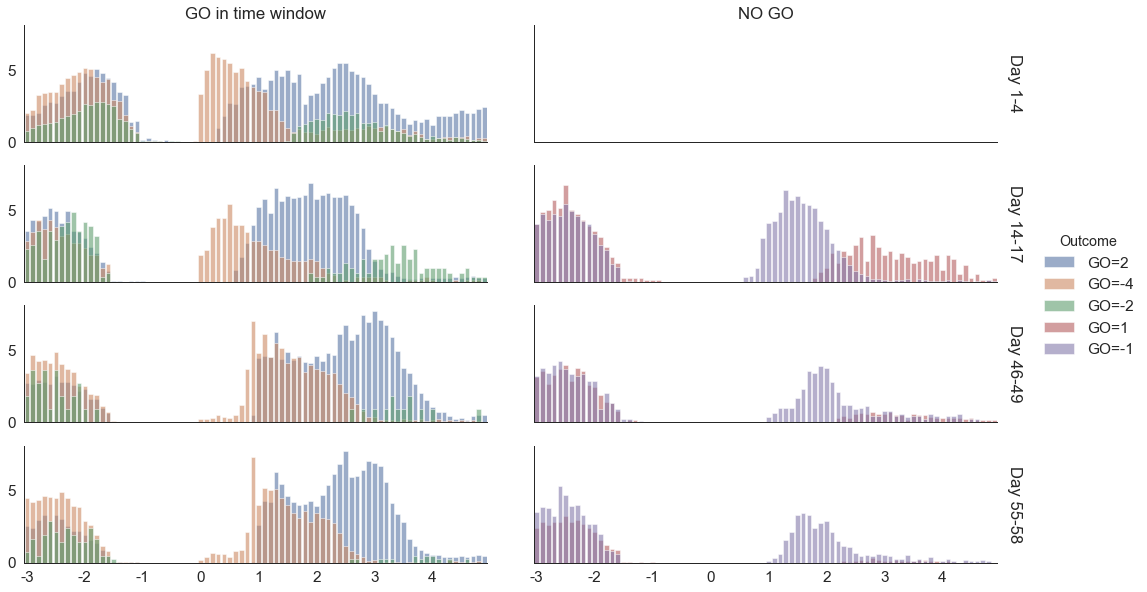

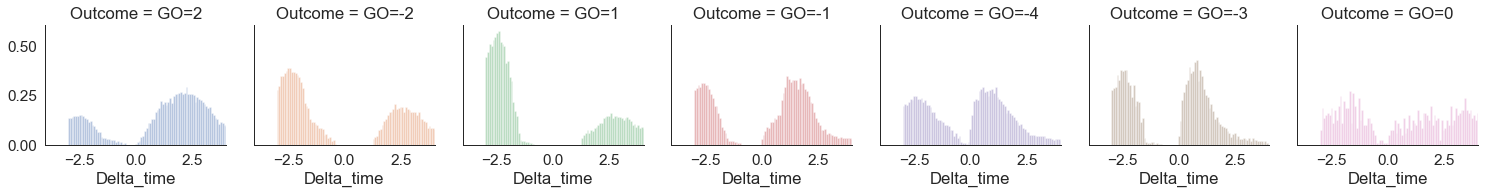

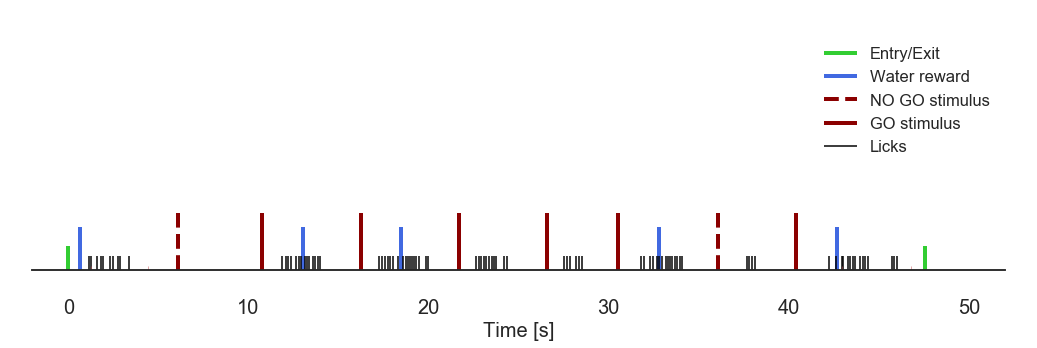

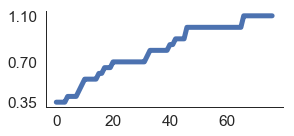

In [29]:
if run =="facetgrid":
    draw_facetgrid()
elif run == "outcome_patterns":
    draw_outcome_patterns()
elif run =="single_session":
    draw_single_session()
elif run =="parameters":
    draw_parameters()
else:
    draw_facetgrid()
    draw_outcome_patterns()
    draw_single_session()
    draw_parameters()

In case the program extends the regular headfix time by a few seconds to finish a started trial, the stimuli are given before the allocated lickwithold time has passed, so basically the program cancels the lickwithold time to start the trial. This can be noticed as licks that "happen during the lickwithold time" of the last trial of some headfix sessions. The process after the stimulus is as usual.
#### This query shows the ratio how often this happens grouped by Outcome (with our usual code)
But it is not prepared to call it from python, but can be used in the `phpmyadmin` GUI, for example on our website

``SELECT SUM(IF(`Licks_within_lickwithhold_time` = "yes" AND `Notes`="GO=1",1,0)) / SUM(IF(`Licks_within_lickwithhold_time` is NULL AND `Notes`="GO=1",1,0)) AS "GO=1",
SUM(IF(`Licks_within_lickwithhold_time` = "yes" AND `Notes`="GO=2",1,0)) / SUM(IF(`Licks_within_lickwithhold_time` is NULL AND `Notes`="GO=2",1,0)) AS "GO=2",
SUM(IF(`Licks_within_lickwithhold_time` = "yes" AND `Notes`="GO=-1",1,0)) / SUM(IF(`Licks_within_lickwithhold_time` is NULL AND `Notes`="GO=-1",1,0)) AS "GO=-1",
SUM(IF(`Licks_within_lickwithhold_time` = "yes" AND `Notes`="GO=-3",1,0)) / SUM(IF(`Licks_within_lickwithhold_time` is NULL AND `Notes`="GO=-3",1,0)) AS "GO=-3",
SUM(IF(`Licks_within_lickwithhold_time` = "yes" AND `Notes`="GO=-2",1,0)) / SUM(IF(`Licks_within_lickwithhold_time` is NULL AND `Notes`="GO=-2",1,0)) AS "GO=-2",
SUM(IF(`Licks_within_lickwithhold_time` = "yes" AND `Notes`="GO=-4",1,0)) / SUM(IF(`Licks_within_lickwithhold_time` is NULL AND `Notes`="GO=-4",1,0)) AS "GO=-4"
FROM `headfix_trials_summary` where 1``